<a href="https://colab.research.google.com/github/a1869470/Deep_Learning/blob/main/DL_Assessment_3_(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
3/3 [==============================] - 0s 8ms/step
Simple RNN Accuracy for Next Day Returns Prediction: 0.4923896499238965


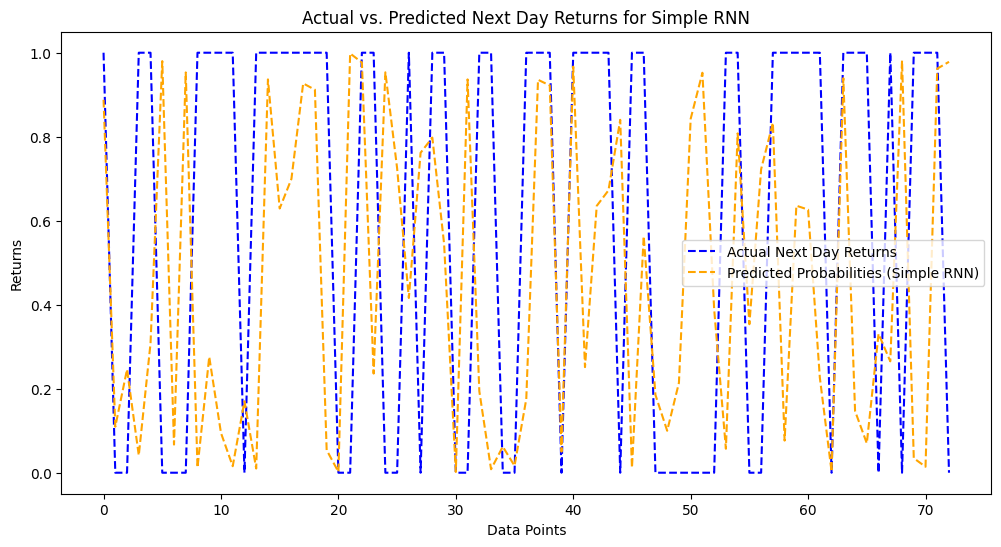

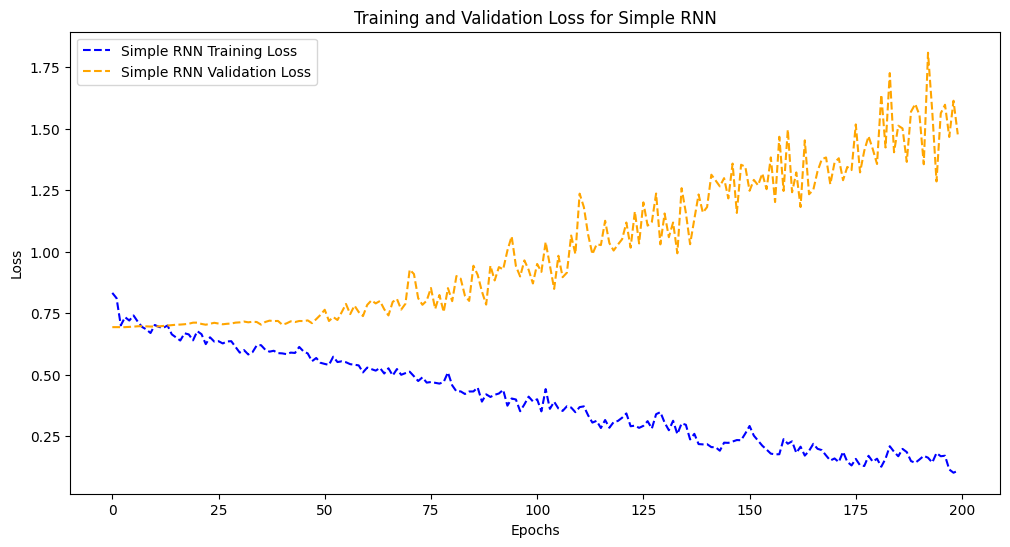

3/3 [==============================] - 1s 9ms/step
LSTM Accuracy for Next Day Returns Prediction: 0.6111111111111112


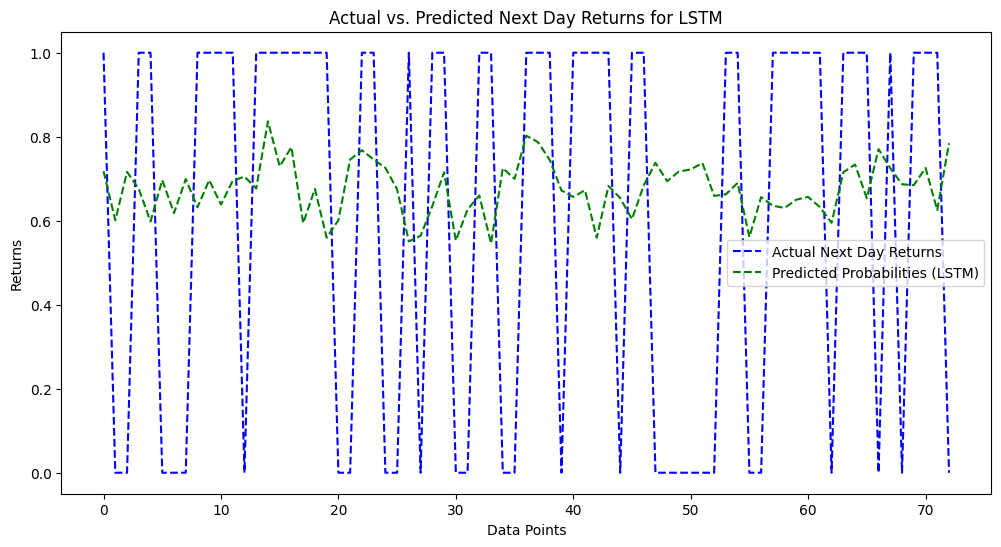

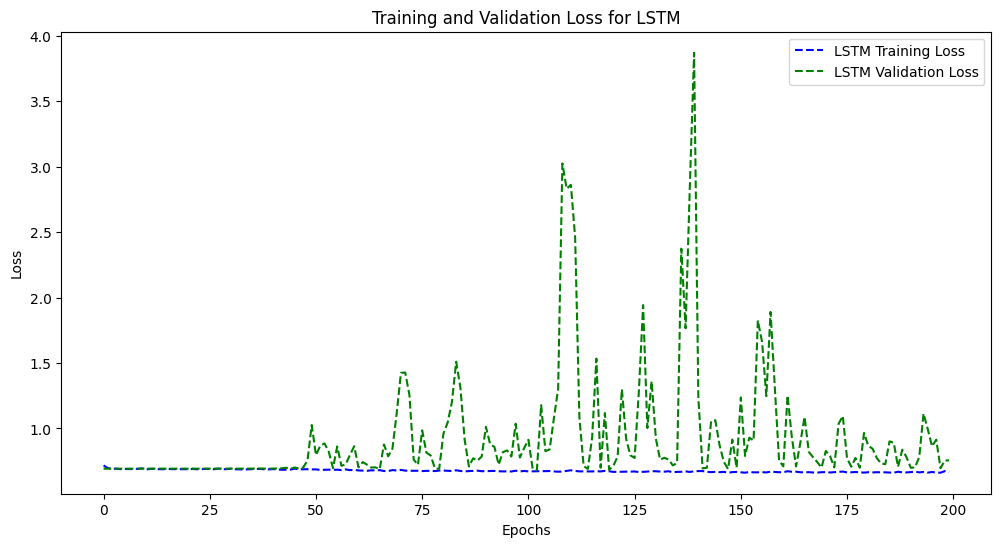

3/3 [==============================] - 1s 12ms/step
GRU Accuracy for Next Day Returns Prediction: 0.4954337899543379


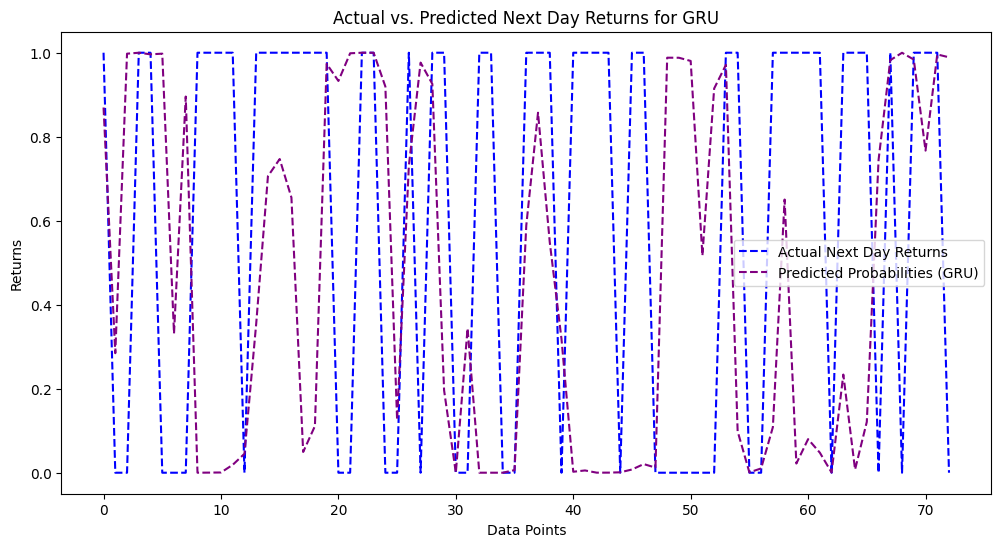

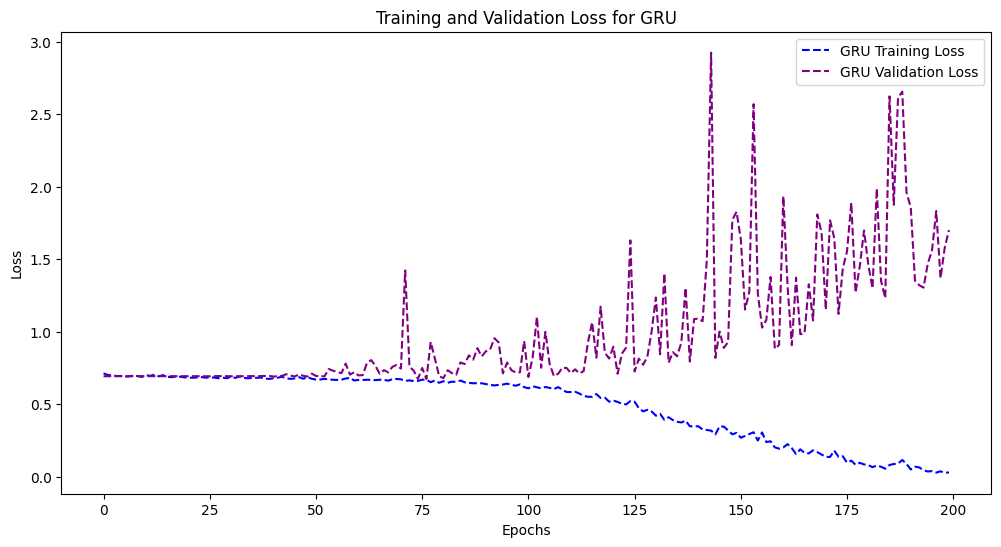

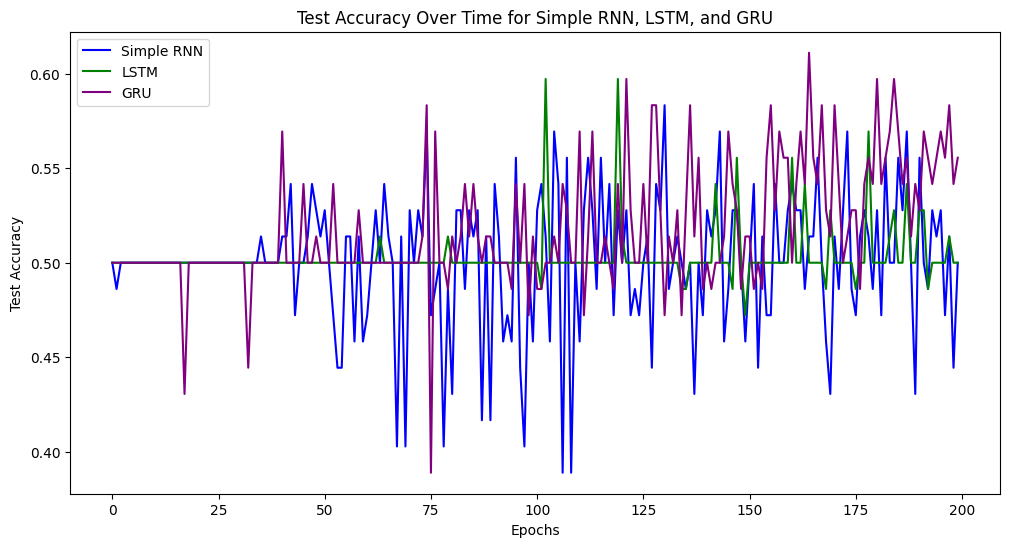

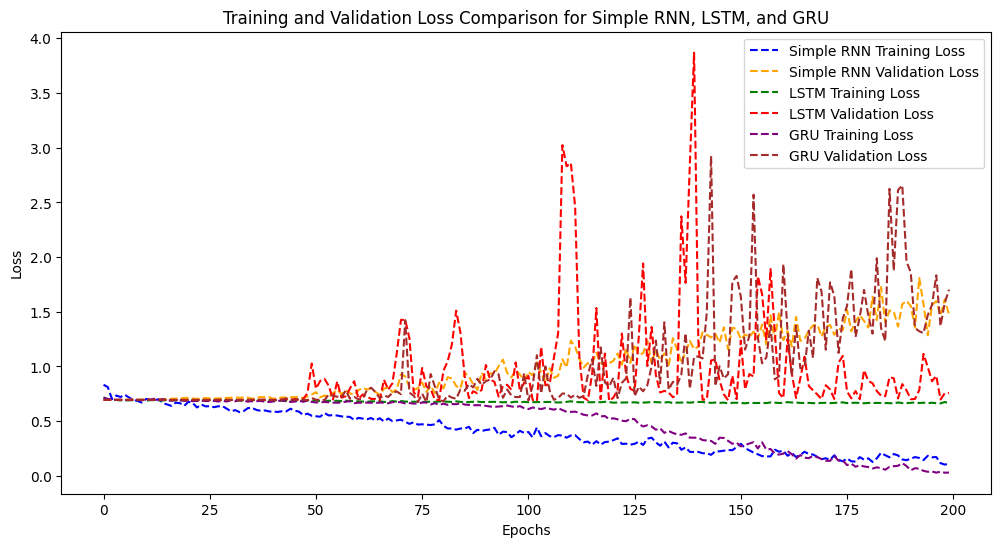

In [39]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, GRU, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

# Fetch historical stock data (e.g., Apple Inc. - 'AAPL')
stock_data = yf.download('AAPL', period='2y')

# Compute daily returns
stock_data['Returns'] = stock_data['Adj Close'].pct_change()
stock_data.dropna(inplace=True)

# Calculate the ratio (price change) between today and the next day
stock_data['Price_Ratio'] = np.where(stock_data['Adj Close'].shift(-1) > stock_data['Adj Close'], 1, 0)

# Use past 20 days to predict the price change next day
lookback_days = 20

X, y = [], []
for i in range(len(stock_data) - lookback_days - 1):
    X.append(stock_data['Returns'].values[i:i + lookback_days])
    y.append(stock_data['Price_Ratio'].values[i + lookback_days])

X = np.array(X)
y = np.array(y)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Adjusted threshold for classification
threshold = 0.5

# Reshape data for LSTM input [samples, time steps, features]
X_train_rnn = np.reshape(X_train, (X_train.shape[0], lookback_days, 1))
X_val_rnn = np.reshape(X_val, (X_val.shape[0], lookback_days, 1))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], lookback_days, 1))

# Build and compile the Simple RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.2))
model_rnn.add(BatchNormalization())
model_rnn.add(SimpleRNN(25, activation='relu'))
model_rnn.add(BatchNormalization())
model_rnn.add(Dense(1, activation='sigmoid'))
optimizer_rnn = Adam(learning_rate=0.001)
model_rnn.compile(optimizer=optimizer_rnn, loss='binary_crossentropy', metrics=['accuracy'])

# Train the Simple RNN model
history_rnn = model_rnn.fit(X_train_rnn, y_train, epochs=200, batch_size=32, validation_data=(X_val_rnn, y_val), verbose=0)

# Evaluate and print accuracy for Simple RNN
predicted_probabilities_rnn = model_rnn.predict(X_test_rnn)
predicted_changes_rnn = (predicted_probabilities_rnn > threshold).astype(int)
accuracy_rnn = np.mean(predicted_changes_rnn == (y_test[:-1] > 0).astype(int))
print(f'Simple RNN Accuracy for Next Day Returns Prediction: {accuracy_rnn}')

# Plot the actual vs. predicted next day returns for Simple RNN
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Next Day Returns', linestyle='dashed', color='blue')
plt.plot(predicted_probabilities_rnn, label='Predicted Probabilities (Simple RNN)', linestyle='dashed', color='orange')
plt.xlabel('Data Points')
plt.ylabel('Returns')
plt.title('Actual vs. Predicted Next Day Returns for Simple RNN')
plt.legend()
plt.show()

# Plot the training and validation loss for Simple RNN
plt.figure(figsize=(12, 6))
plt.plot(history_rnn.history['loss'], label='Simple RNN Training Loss', linestyle='dashed', color='blue')
plt.plot(history_rnn.history['val_loss'], label='Simple RNN Validation Loss', linestyle='dashed', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Simple RNN')
plt.legend()
plt.show()

# Build and compile an LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(1, activation='sigmoid'))
optimizer_lstm = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer_lstm, loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history_lstm = model_lstm.fit(X_train_rnn, y_train, epochs=200, batch_size=32, validation_data=(X_val_rnn, y_val), verbose=0)

# Adjusted threshold for classification
threshold = 0.5

# Evaluate and print accuracy for LSTM
predicted_probabilities_lstm = model_lstm.predict(X_test_rnn)
predicted_changes_lstm = (predicted_probabilities_lstm > threshold).astype(int)
accuracy_lstm = np.mean(predicted_changes_lstm == (y_test[:-1] > 0).astype(int))
print(f'LSTM Accuracy for Next Day Returns Prediction: {accuracy_lstm}')

# Plot the actual vs. predicted next day returns for LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Next Day Returns', linestyle='dashed', color='blue')
plt.plot(predicted_probabilities_lstm, label='Predicted Probabilities (LSTM)', linestyle='dashed', color='green')
plt.xlabel('Data Points')
plt.ylabel('Returns')
plt.title('Actual vs. Predicted Next Day Returns for LSTM')
plt.legend()
plt.show()

# Plot the training and validation loss for LSTM
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss', linestyle='dashed', color='blue')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss', linestyle='dashed', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for LSTM')
plt.legend()
plt.show()

# Build and compile a GRU model for classification
model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(GRU(50, return_sequences=False))
model_gru.add(BatchNormalization())
model_gru.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification
optimizer_gru = Adam(learning_rate=0.001)
model_gru.compile(optimizer=optimizer_gru, loss='binary_crossentropy', metrics=['accuracy'])

# Train the GRU model
history_gru = model_gru.fit(X_train_rnn, y_train, epochs=200, batch_size=32, validation_data=(X_val_rnn, y_val), verbose=0)

# Evaluate and print accuracy for GRU
predicted_probabilities_gru = model_gru.predict(X_test_rnn)
predicted_changes_gru = (predicted_probabilities_gru > threshold).astype(int)
accuracy_gru = np.mean(predicted_changes_gru == (y_test[:-1] > 0).astype(int))
print(f'GRU Accuracy for Next Day Returns Prediction: {accuracy_gru}')

# Plot the actual vs. predicted next day returns for GRU
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Next Day Returns', linestyle='dashed', color='blue')
plt.plot(predicted_probabilities_gru, label='Predicted Probabilities (GRU)', linestyle='dashed', color='purple')
plt.xlabel('Data Points')
plt.ylabel('Returns')
plt.title('Actual vs. Predicted Next Day Returns for GRU')
plt.legend()
plt.show()

# Plot the training and validation loss for GRU
plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['loss'], label='GRU Training Loss', linestyle='dashed', color='blue')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss', linestyle='dashed', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for GRU')
plt.legend()
plt.show()

# Plot test accuracy over time for all models
plt.figure(figsize=(12, 6))
plt.plot(history_rnn.history['val_accuracy'], label='Simple RNN', color='blue')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM', color='green')
plt.plot(history_gru.history['val_accuracy'], label='GRU', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Over Time for Simple RNN, LSTM, and GRU')
plt.legend()
plt.show()

# Plot the training and validation loss for all models
plt.figure(figsize=(12, 6))
plt.plot(history_rnn.history['loss'], label='Simple RNN Training Loss', linestyle='dashed', color='blue')
plt.plot(history_rnn.history['val_loss'], label='Simple RNN Validation Loss', linestyle='dashed', color='orange')
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss', linestyle='dashed', color='green')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss', linestyle='dashed', color='red')
plt.plot(history_gru.history['loss'], label='GRU Training Loss', linestyle='dashed', color='purple')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss', linestyle='dashed', color='brown')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison for Simple RNN, LSTM, and GRU')
plt.legend()
plt.show()